# Project - MUSIC GENRE CLASSIFICATION

Link for the submission - https://drive.google.com/drive/folders/1Dme_j_X0lCOSLvZx1etPZciOHfrvVUcr?usp=sharing

## Team - Flipping - a - Coin 
### 1. Lakshay Chawla
### 2. Shambhavi Aggarwal
### 3. Devansh Shrestha
### 4. Rommel Jalasutram
### 5. Varnika Vatsyayan

### Aim - To build a machine learning model which classifies music into its respective genre.

# Introduction -
### Intrigued by the audio domain, we decided to pick up this project, wherein we have to classify different songs belonging to differrent genres to their respective genres using deep learning models.
Before moving ahead, let's talk about the challenges to work with audio data.
First and foremost , it is not possible to visualize an audio file, that is we can't represent the audio file in like a graph.

#### To start with processing, we need to first understand what audio signal is.
#### 1. Produced by the vibration of an object
#### 2. Vibrations determine oscillation of air molecules
#### 3. Alternation of air pressure causes a wave 

#### Libraries to be used

In [ ]:
import os                                             # To walk through directories.
import datetime                                       # to get date-time.
import math                                           # To perform common math calculations.
import json                                           # To save dataset in a json format.
import numpy as np                                    # To perform array calculations.
import pandas as pd                                   # To work easily with dataframes
import librosa, librosa.display                       # To preprocess audio.
import matplotlib.pyplot as plt                       # To plot necessary graphs.  
import seaborn as sns                                 # To plot necessary graphs.
from IPython.display import Image                     # To show images.
from prettytable import PrettyTable                   # To present the outputs in a nice format.
# To make the graphs visible inline with the notebook.
%matplotlib inline                                    
from sklearn.model_selection import train_test_split  # To split dataset for training and testing.

## Tensorflow modules for making different deep learning mdoels and evaluating them.

import tensorflow as tf
from tensorflow.keras import models                   
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense,Flatten,Input,Dropout,BatchNormalization,Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix

## Modules required for saliency maps.

from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from matplotlib import cm

# To launch tensorboard.
%load_ext tensorboard                             

While working with libraries of various versions, we get a lot of unnecessary warnings. To remove the warnings and make the notebook cleaner, we used the following library

In [ ]:
## To remove warnings.

import warnings
warnings.filterwarnings("ignore")

Make a variable for the dataset path.

In [ ]:
DATASET_PATH = "Data/genres_original"

Make a variable having all the labels.

In [ ]:
labels = ['disco', 'metal', 'reggae','blues','rock','classical','jazz','hiphop','country','pop']

## EDA / Visualisation

#### Step - 1) Analog to digital conversion

When audio signal that is inherently analog has to be processed, we need to convert it to Digital signal first.
To convert it to digital , the signal is sampled at uniform time intervals. The number of times it is sampled each second is known as Sample Rate.
Conversion of amplitude of the signal takes place with limited number of bits. The number of bits used for amplitude quantisation is known as Bit Depth.
A typical CD album has a Sample Rate = 44,100 Hz and Bit Depth = 16. 

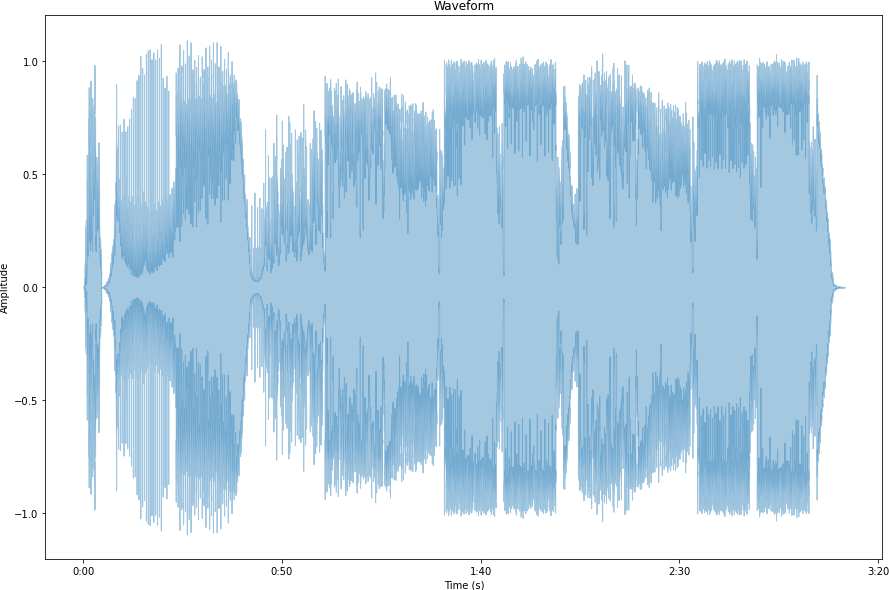

In [ ]:
Image(filename='Waveform.png')

#### Step - 2) FFT - Fast Fourier Transform

Fourier transform decomposes complex periodic sound into sum of sine
waves oscillating at different frequencies. 
After fourier transform, the sound wave gets changed from time domain to
frequency domain. 

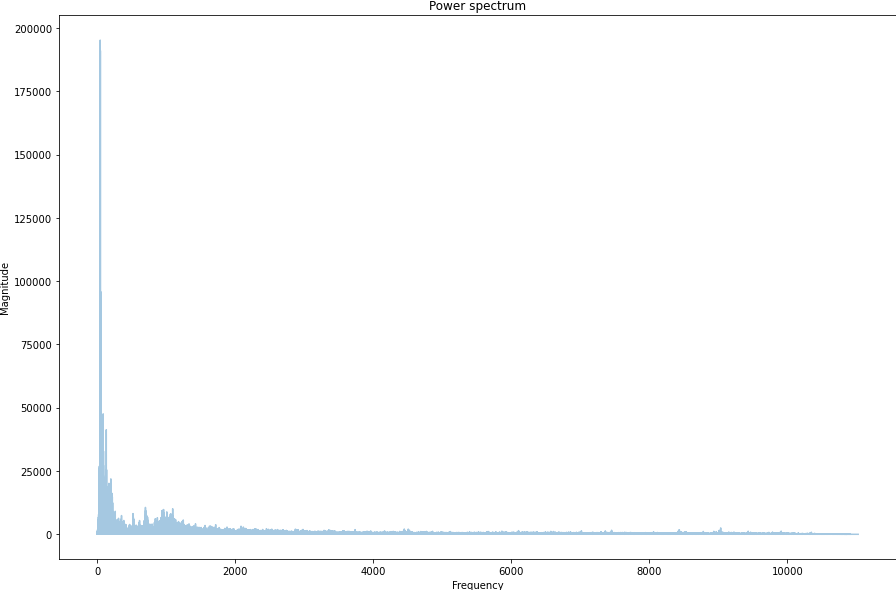

In [ ]:
Image(filename='fft.png')

#### Step - 3) STFT - Short Time Fourier Transform

1. Computes several FFT at different intervals
2. Preserves time information
3. Fixed frame size (e.g., 2048 samples)
4. Gives a spectrogram (time + frequency + magnitude) 


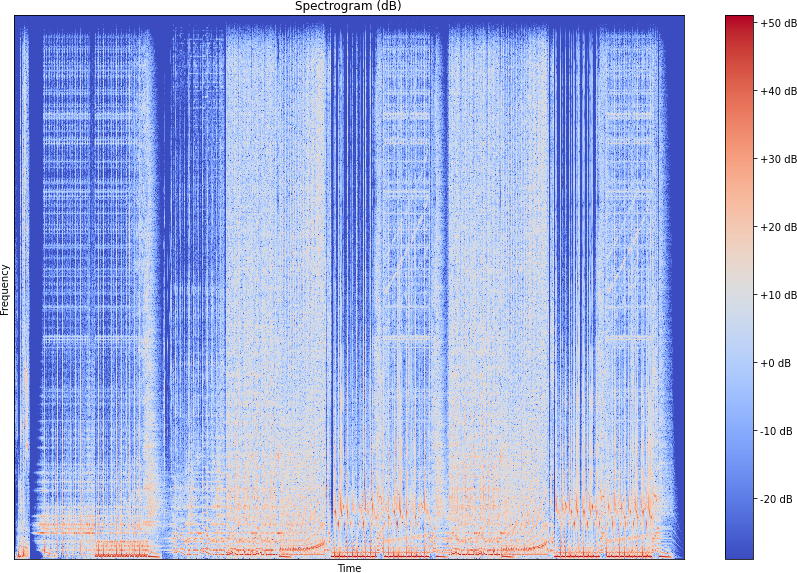

In [ ]:
Image(filename='stft.png')

#### Step - 4) MFCCs - MEL FREQUENCY CEPSTRAL COEFFICIENTS 

1. Capture timbral/textural aspects of sound
2. Frequency domain feature
3. Approximate human auditory system
4. 13 to 40 coefficients
5. Calculated at each frame 

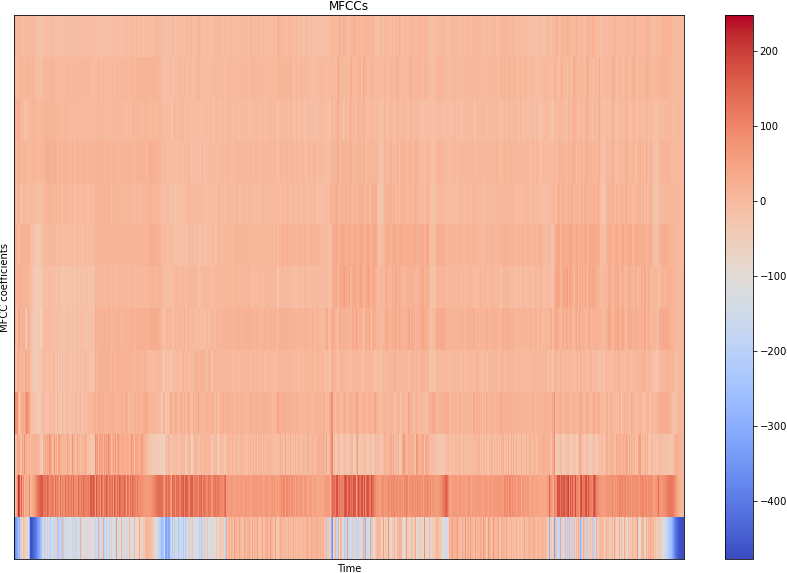

In [ ]:
Image(filename='mfcc.png')

In [ ]:
def load_file(file):
    signal, sample_rate = librosa.load(file, sr=22050)
    return signal, sample_rate

In [ ]:
def plot_waveform(signal, sample_rate):
    # WAVEFORM
    # display waveform
    librosa.display.waveshow(signal, sample_rate, alpha=0.4, color = '#0afa9e')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Waveform")

In [ ]:
def plot_fft(signal, sample_rate):
    # FFT -> power spectrum
    # perform Fourier transform
    fft = np.fft.fft(signal)

    # calculate abs values on complex numbers to get magnitude
    spectrum = np.abs(fft)

    # create frequency variable
    f = np.linspace(0, sample_rate, len(spectrum))

    # plot spectrum
    plt.plot(f, spectrum, alpha=0.4, color = '#0afa9e')
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.title("Power spectrum")

In [ ]:
def calculate_stft(signal, sample_rate):
    # STFT -> spectrogram
    hop_length = 512 # in num. of samples
    n_fft = 2048 # window in num. of samples

    # calculate duration hop length and window in seconds
    hop_length_duration = float(hop_length)/sample_rate
    n_fft_duration = float(n_fft)/sample_rate

    #print("STFT hop length duration is: {}s".format(hop_length_duration))
    #print("STFT window duration is: {}s".format(n_fft_duration))

    # perform stft
    stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

    # calculate abs values on complex numbers to get magnitude
    spectrogram = np.abs(stft)

    return spectrogram, hop_length

In [ ]:
def plot_stft(signal, sample_rate):
    # apply logarithm to cast amplitude to Decibels
    spectrogram, hop_length = calculate_stft(signal, sample_rate)
    log_spectrogram = librosa.amplitude_to_db(spectrogram)

    librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar(format="%+2.0f dB")
    plt.title("Spectrogram (dB)")

In [ ]:
def plot_mfcc(signal, sample_rate):
    # MFCCs
    # extract 13 MFCCs
    hop_length = 512 # in num. of samples
    n_fft = 2048 # window in num. of samples
    MFCCs = librosa.feature.mfcc(signal, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

    # display MFCCs
    
    librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
    plt.xlabel("Time")
    plt.ylabel("MFCC coefficients")
    plt.colorbar()
    plt.title("MFCCs")

    # show plots
    plt.savefig('mfcc.png',bbox_inches='tight',pad_inches = 0)
    plt.show()
    return MFCCs

In [ ]:
def get_record_count(path):
    dictionary = {}
    for i, j in enumerate(os.walk(path)):
        if i == 0:
            continue
        dictionary[j[2][1].split('.')[0].capitalize()] = len(j[2])
    return dictionary

In [ ]:
def plot_record_count(path):
    records = get_record_count(path)
    plt.figure(figsize=(10,5))
    plt.bar(records.keys(),records.values(),color = '#0afa9e')
    plt.ylim(0,120)
    plt.xlabel('Genre')
    plt.ylabel('Record Count')
    plt.title('Record count of each genre')
    plt.show()
    return records

In [ ]:
def plot_visualisations(file):
    # Call the load_file function.
    
    signal, sample_rate = load_file(file)
    
    
    plt.figure(figsize = (15,3))
    # Plot the waveform.
    
    plt.subplot(1,4,1)
    plot_waveform(signal, sample_rate)
    
    #PLot FFTs.
    
    plt.subplot(1,4,2)
    plot_fft(signal, sample_rate)
    
    # Plot STFTs.
    
    plt.subplot(1,4,3)
    plot_stft(signal, sample_rate)
    
    #Plot MFCCs.
    
    plt.subplot(1,4,4)
    plot_mfcc(signal,sample_rate)

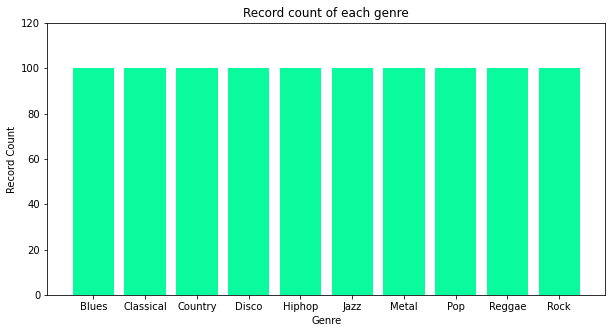

In [ ]:
records_dictionary = plot_record_count(DATASET_PATH)

				Visualisation of an audio file of Blues genre.


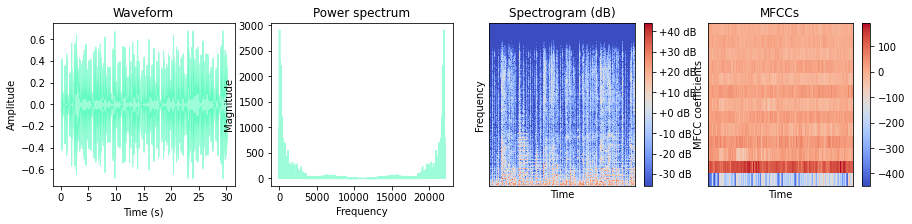

				Visualisation of an audio file of Classical genre.


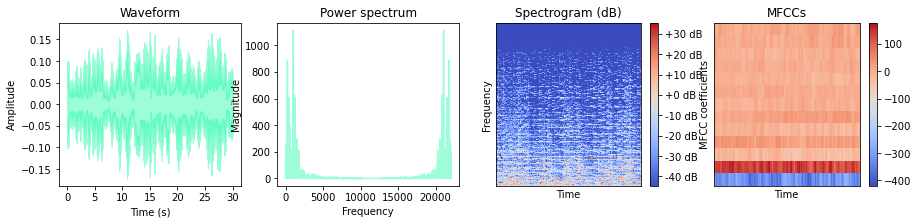

				Visualisation of an audio file of Country genre.


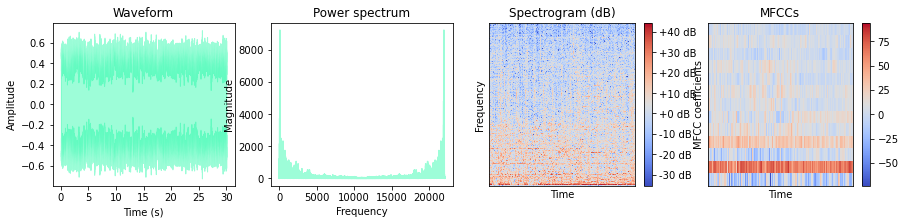

				Visualisation of an audio file of Disco genre.


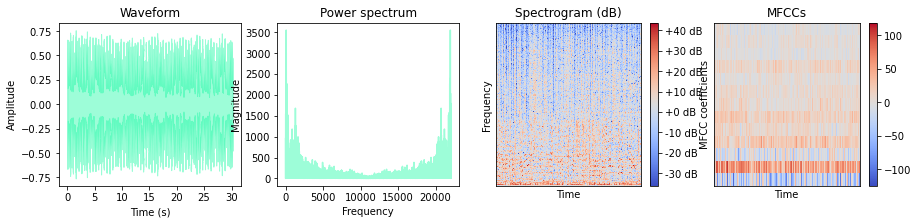

				Visualisation of an audio file of Hiphop genre.


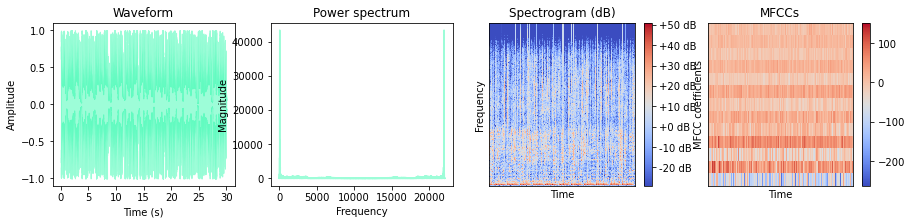

				Visualisation of an audio file of Jazz genre.


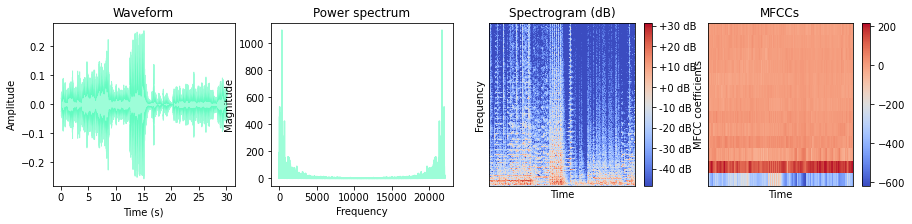

				Visualisation of an audio file of Metal genre.


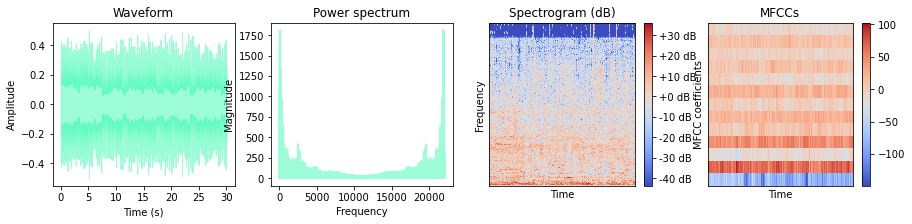

				Visualisation of an audio file of Pop genre.


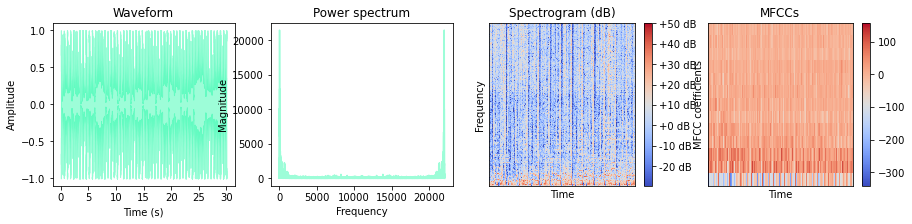

				Visualisation of an audio file of Reggae genre.


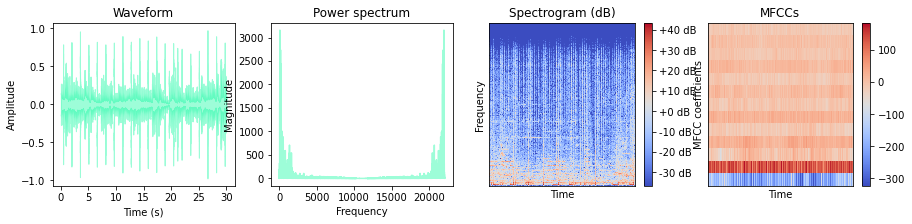

				Visualisation of an audio file of Rock genre.


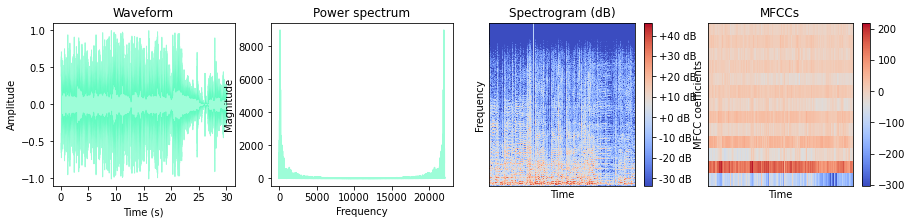

In [ ]:
for i, j in enumerate(os.walk(DATASET_PATH)):
    if i == 0:
        continue
    file = DATASET_PATH +'/' + j[2][1].split('.')[0] + '/' + j[2][1]
    print(f"\t\t\t\tVisualisation of an audio file of {j[2][1].split('.')[0].capitalize()} genre.")
    plot_visualisations(file)

## About the Dataset

Link to the dataset - https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

#### GTZAN Dataset
#### 10 genres
#### 100 songs per genre
#### 30 seconds per song

## Pre - Processing

## Preprocessing Library Used - Librosa

#### Librosa is a Python package for music and audio analysis. Librosa is basically used when we work with audio data like in music generation, Automatic Speech Recognition. It provides the building blocks necessary to create the music information retrieval systems.

 To manipulate such a dataset was a hassle. We decided to turn that dataset in a json file after preprocessing to remove computation overhead everytime we run the notebook.
 The following function converts the audio files to MFCCs, which we will be using for classification and saves them in JSON format.
 Also, to Counter with the fact that the dataset is relatively small, implementing data augmentation we split each file into 3 seconds chunks and processed those chunks instead of complete audio files.

Variables used in the function are - 

    
Arguments:
n_mfcc = no of coefficient in mfcc
n_fft = no of fft
hop_length = window length to move, similar to stride
num_segment = chopping one audio to 5 segments to increase data for training
    
Steps:
1. Make dictionary to store data
    
    Dictionary has 3 keys
    
    a. mapping: the numerical label for each genre
    
    b. mfcc: training data; x_train
    
    c. labels: y_train
        

2. Iterate through folder of each genre
    


3. Divide each audio clip into 5 segment and create mfcc 
    

Create a variable for JSON path.

In [ ]:
JSON_PATH = "data.json"

Function to pre-process the dataset and store it in JSON file format.

In [ ]:
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    
    # make dictionary to store data
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": []
    }
    
    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)
    
    # loop through all the genres
    for i, walk_items in enumerate(os.walk(dataset_path)):
        
        dirpath, dirnames, filenames = walk_items[0], walk_items[1], walk_items[2]
        
        # ensure we are not at the root level
        # os.walk will give the root dir in the 1st iteration
        if dirpath is not dataset_path:
            
            # save mapping label
            mapping_label = os.path.basename(dirpath)
            data["mapping"].append(mapping_label)
            print(f"Processing {mapping_label}")

            # loop through file names
            for f in filenames:
                
                try:
                
                    # load audio file
                    file_path = os.path.join(dirpath, f)
                    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                    # divide the signal into 5 segments
                    # then create mfcc of all segment
                    for s in range(num_segments):

                        start_sample = num_samples_per_segment * s
                        finish_sample = start_sample + num_samples_per_segment

                        mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],
                                                   sr=sr,
                                                   n_fft=n_fft,
                                                   n_mfcc=n_mfcc,
                                                   hop_length=hop_length)

                        mfcc = mfcc.T

                        # store mfcc for segment if it has expected length
                        if len(mfcc) == expected_num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            print(f" {f}, segment: {s}")

                except:
                    print(f"Something is wrong with the file {f}")
                        
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

Calling the function.

In [ ]:
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

## Load dataset

After, converting the dataset to JSON format, it became easy to import the dataset and use the MFCCs calculated for the classification of audio files.

In [ ]:
## Function to load JSON file.
def load_json(path):
    with open(path,'r') as fp:
        data = json.load(fp)
        
        X = np.array(data['mfcc'])
        y= np.array(data['labels'])
        return X,y

In [ ]:
# Call the function.
X,y = load_json(JSON_PATH)

## Split into training and testing

To make sure that our model is reliable, we need to split the data into training and testing sets. The evaluation of the model on testing set represents what the model will behave like in real world. 

In [ ]:
# Split the data with train size = 70%.
x_train,x_test,y_train,y_test  = train_test_split(X,y,train_size=0.7)

## FFNNs - Feed Forward Neural Networks

An FFNN consists of a large number of neurons, organized in layers: one input layer, one or more hidden layers, and one output layer. Each neuron in a layer is connected to all the neurons of the previous layer, although the connections are not all the same because they have different weights. The weights of these connections encode the knowledge of the network. Data enters at the inputs and passes through the network, layer by layer until it arrives at the outputs. During this operation, there is no feedback between layers. Therefore, these types of networks are called feed-forward neural networks.

#### What are Optimizers?

Optimizers are algorithms or methods used to change the attributes of the neural network such as weights and learning rate to reduce the losses. Optimizers are used to solve optimization problems by minimizing the function.

#### Challenges in Optimization - Saddle Points

• In large N-dimensional domains, local minima are extremely rare.
• Saddle points are very common in high dimensional spaces.
• These saddle points make it notoriously hard for SGD to escape, as the gradient is close to zero in all dimensions.

#### Escaping saddle points
Somewhat counterintuitively, the best way to escape saddle points is to
just move in any direction, quickly.
Then we can get somewhere with more substantial curvature for a more
informed update

Types of layers used -
1. Dense
2. Flatten
3. Dropout
4. Batch Normalization

#### Flatten Layer
This layer helps to convert an n-dimensional array into 1-dimensional array.

#### Dropout Layers
• Randomly set some neurons and their connections to zero (i.e. “dropped”).

• Prevent overfitting by reducing co-adaptation of neurons.

• Like training many random sub-networks.

#### Batch Normalization Layers
Batch Norm is just another network layer that gets inserted between a hidden layer and the next hidden layer. Its job is to take the outputs from the first hidden layer and normalize them before passing them on as the input of the next hidden layer

#### Confusion Matrix

A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known. The confusion matrix itself is relatively simple to understand, but the related terminology can be confusing.

#### Tensorboard
TensorBoard provides the visualization and tooling needed for machine learning experimentation:

1. Tracking and visualizing metrics such as loss and accuracy

2. Visualizing the model graph (ops and layers)

3. Viewing histograms of weights, biases, or other tensors as they change over time

4. Projecting embeddings to a lower dimensional space

5. Displaying images, text, and audio data

6. Profiling TensorFlow programs

### Model - 1

Layers Used - Dense, Flatten
Regularizer Used - None
Callbacks Used - None

In [ ]:
optimizer = optimizers.Adam(learning_rate=0.01)  ## defining the optimizer as Adam with learning rate  0.01.

In [ ]:
ffnn_model = models.Sequential(name="FFNN")
# The Inputs
ffnn_model.add(Input(shape=(X.shape[1],X.shape[2])))
# flatten layer
ffnn_model.add(Flatten())
# first dense layer
ffnn_model.add(Dense(512,activation='relu',name='dense1'))
# second dense layer
ffnn_model.add(Dense(256,activation='relu',name='dense2'))
# third dense layer
ffnn_model.add(Dense(128,activation='relu',name='dense3'))
# fourth dense layer
ffnn_model.add(Dense(64,activation='relu',name='dense4'))
# fifth dense layer
ffnn_model.add(Dense(32,activation='relu',name='dense5'))
# Output layer
ffnn_model.add(Dense(10,activation='softmax',name='output'))
# Print the model summary.
print(ffnn_model.summary())
# Compile the model.
ffnn_model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# Fit the model and store the history in a varibale.
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history1=ffnn_model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50,batch_size=32, callbacks = tensorboard_callback, verbose = 0)

Model: "FFNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 1690)              0         
_________________________________________________________________
dense1 (Dense)               (None, 512)               865792    
_________________________________________________________________
dense2 (Dense)               (None, 256)               131328    
_________________________________________________________________
dense3 (Dense)               (None, 128)               32896     
_________________________________________________________________
dense4 (Dense)               (None, 64)                8256      
_________________________________________________________________
dense5 (Dense)               (None, 32)                2080      
_________________________________________________________________
output (Dense)               (None, 10)                330    

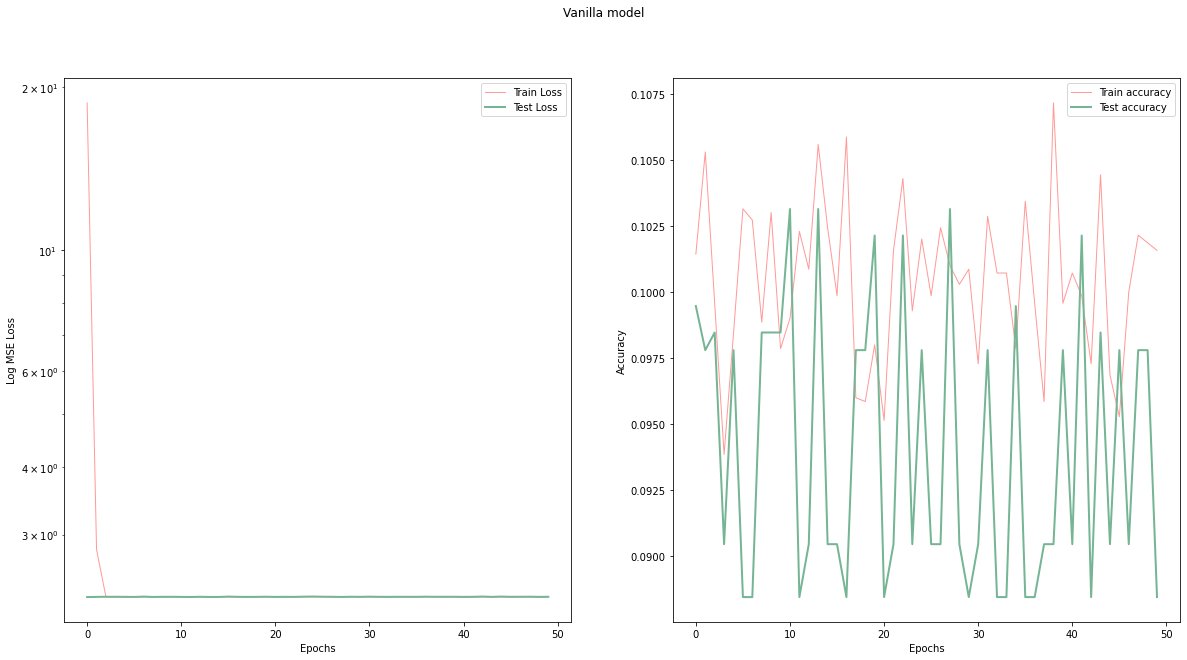

In [ ]:
fig,ax =plt.subplots(1,2,figsize=(20,10))
fig.suptitle("Vanilla model")
ax[0].semilogy(history1.history['loss'], label='Train Loss', color='#FF9A98', linewidth=1)
ax[0].semilogy(history1.history['val_loss'],  label='Test Loss', color='#75B594', linewidth=2)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Log MSE Loss')
ax[0].legend()

ax[1].plot(history1.history['accuracy'], label='Train accuracy', color='#FF9A98', linewidth=1)
ax[1].plot(history1.history['val_accuracy'],  label='Test accuracy', color='#75B594', linewidth=2)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

### Model - 2

Layers Used - Dense, Flatten, Dropout
Regularizer Used - L2
Callbacks Used - None

In [ ]:
reg = regularizers.l2(0.001)

In [ ]:
ffnn_model2 = models.Sequential(name='FfnnReg')

ffnn_model2.add(Input(shape=(X.shape[1],X.shape[2])))
# flatten layer
ffnn_model2.add(Flatten())
# first dense layer
#ffnn_model2.add(Dense(512,activation='relu',kernel_regularizer=reg,name='dense1'))
#ffnn_model2.add(Dropout(rate=0.3))
# second dense layer
ffnn_model2.add(Dense(256,activation='relu',kernel_regularizer=reg,name='dense2'))
ffnn_model2.add(Dropout(rate=0.3))
# third dense layer
ffnn_model2.add(Dense(128,activation='relu',kernel_regularizer=reg,name='dense3'))
ffnn_model2.add(Dropout(rate=0.3))
# fourth dense layer
ffnn_model2.add(Dense(64,activation='relu',kernel_regularizer=reg,name='dense4'))
ffnn_model2.add(Dropout(rate=0.3))
# fifth dense layer
ffnn_model2.add(Dense(32,activation='relu',kernel_regularizer=reg,name='dense5'))
ffnn_model2.add(Dropout(rate=0.3))
# Output layer
ffnn_model2.add(Dense(10,activation='softmax',name='output'))
# Print the model summary
print(ffnn_model2.summary())
# Compile the model.
ffnn_model2.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# Fit the model and store the history in a varibale.
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history2=ffnn_model2.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=32, callbacks = tensorboard_callback, verbose = 0)

Model: "FfnnReg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 1690)              0         
_________________________________________________________________
dense2 (Dense)               (None, 256)               432896    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense3 (Dense)               (None, 128)               32896     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense4 (Dense)               (None, 64)                8256      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0   

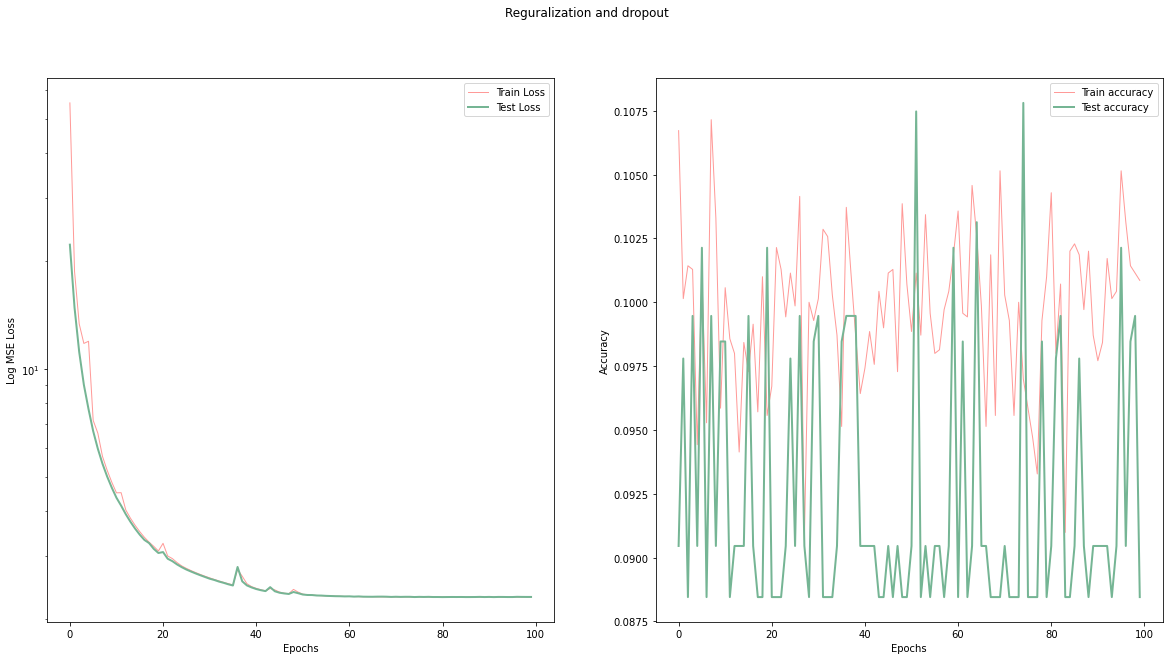

In [ ]:
fig,ax =plt.subplots(1,2,figsize=(20,10))
fig.suptitle("Reguralization and dropout")
ax[0].semilogy(history2.history['loss'], label='Train Loss', color='#FF9A98', linewidth=1)
ax[0].semilogy(history2.history['val_loss'],  label='Test Loss', color='#75B594', linewidth=2)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Log MSE Loss')
ax[0].legend()

ax[1].plot(history2.history['accuracy'], label='Train accuracy', color='#FF9A98', linewidth=1)
ax[1].plot(history2.history['val_accuracy'],  label='Test accuracy', color='#75B594', linewidth=2)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

### Model - 3

Layers Used - Dense, Flatten
Regularizer Used - None
Callbacks Used - Early Stopping, Learning Rate Scheduler

In [ ]:
def scheduler(epoch,lr):
    if epoch<10:
        return lr
    else:
        return lr*math.exp(-0.1)
    
my_callbacks=[EarlyStopping(monitor="val_loss",patience=10),
             LearningRateScheduler(scheduler)]

In [ ]:
ffnn_model3 = models.Sequential(name="call")
# The Inputs
ffnn_model3.add(Input(shape=(X.shape[1],X.shape[2])))
# flatten layer
ffnn_model3.add(Flatten())
# first dense layer
ffnn_model3.add(Dense(512,activation='relu',name='dense1'))
# second dense layer
ffnn_model3.add(Dense(256,activation='relu',name='dense2'))
# third dense layer
ffnn_model3.add(Dense(128,activation='relu',name='dense3'))
# fourth dense layer
ffnn_model3.add(Dense(64,activation='relu',name='dense4'))
# fifth dense layer
#ffnn_model3.add(Dense(32,activation='relu',name='dense5'))
# Output layer
ffnn_model3.add(Dense(10,activation='softmax',name='output'))
# Print the model summary
print(ffnn_model3.summary())
# Compile the model.
ffnn_model3.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# Fit the model and store the history in a varibale.
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
my_callbacks.append(tensorboard_callback)
history3=ffnn_model3.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=32, callbacks = my_callbacks, verbose = 0)

Model: "call"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 1690)              0         
_________________________________________________________________
dense1 (Dense)               (None, 512)               865792    
_________________________________________________________________
dense2 (Dense)               (None, 256)               131328    
_________________________________________________________________
dense3 (Dense)               (None, 128)               32896     
_________________________________________________________________
dense4 (Dense)               (None, 64)                8256      
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 1,038,922
Trainable params: 1,038,922
Non-trainable params: 0
____________________________________________________

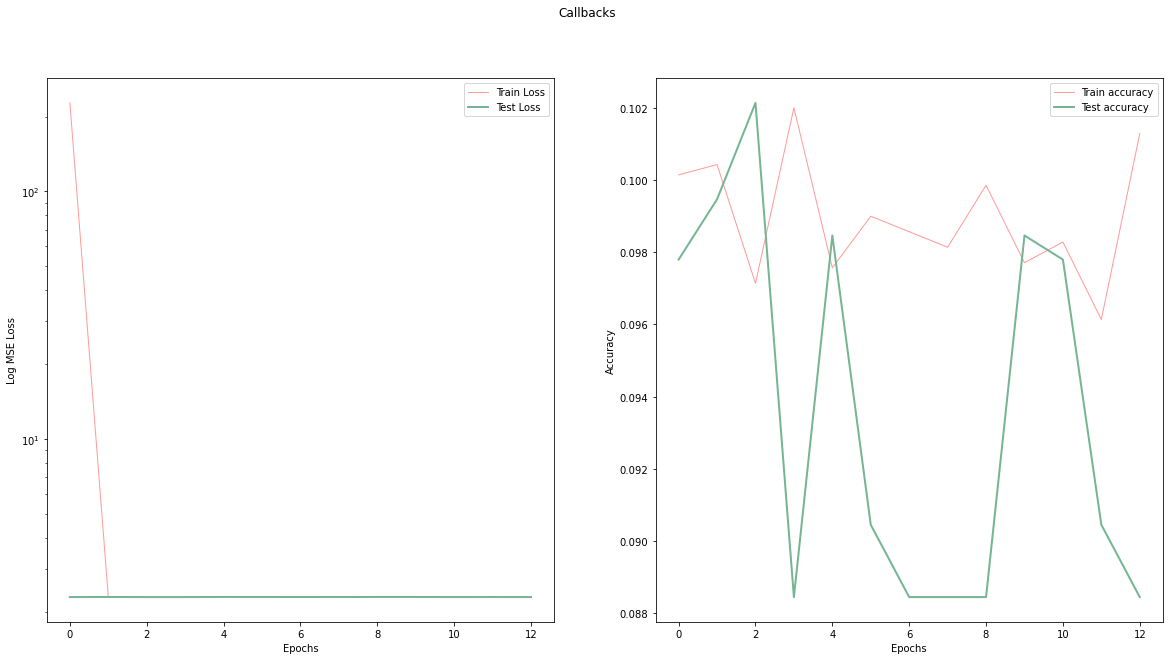

In [ ]:
fig,ax =plt.subplots(1,2,figsize=(20,10))
fig.suptitle("Callbacks")
ax[0].semilogy(history3.history['loss'], label='Train Loss', color='#FF9A98', linewidth=1)
ax[0].semilogy(history3.history['val_loss'],  label='Test Loss', color='#75B594', linewidth=2)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Log MSE Loss')
ax[0].legend()

ax[1].plot(history3.history['accuracy'], label='Train accuracy', color='#FF9A98', linewidth=1)
ax[1].plot(history3.history['val_accuracy'],  label='Test accuracy', color='#75B594', linewidth=2)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

### Model 4

Layers Used - Dense, Flatten, Droupout
Regularizer Used - L2
Callbacks Used - Early Stopping, Learning Rate Scheduler

In [ ]:
def scheduler2(epoch,lr):
    if epoch<10:
        return lr
    else:
        return lr*math.exp(-0.01)
    
my_callbacks2=[EarlyStopping(monitor="val_loss",patience=10),
             LearningRateScheduler(scheduler2)]

In [ ]:
reg = regularizers.l2(0.001)
ffnn_model4 = models.Sequential(name='FfnnReg_call')

ffnn_model4.add(Input(shape=(X.shape[1],X.shape[2])))
# flatten layer
ffnn_model4.add(Flatten())
# first dense layer
#ffnn_model4.add(Dense(512,activation='relu',kernel_regularizer=reg,name='dense1'))
#ffnn_model4.add(Dropout(rate=0.3))
# second dense layer
ffnn_model4.add(Dense(256,activation='relu',kernel_regularizer=reg,name='dense2'))
ffnn_model4.add(Dropout(rate=0.3))
# third dense layer
ffnn_model4.add(Dense(128,activation='relu',kernel_regularizer=reg,name='dense3'))
ffnn_model4.add(Dropout(rate=0.3))
# fourth dense layer
ffnn_model4.add(Dense(64,activation='relu',kernel_regularizer=reg,name='dense4'))
ffnn_model4.add(Dropout(rate=0.3))
# fifth dense layer
#ffnn_model4.add(Dense(32,activation='relu',kernel_regularizer=reg,name='dense5'))
#ffnn_model4.add(Dropout(rate=0.3))
# Output layer
ffnn_model4.add(Dense(10,activation='softmax',name='output'))
# Print the model summary
print(ffnn_model4.summary())
# Compile the model.
ffnn_model4.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# Fit the model and store the history in a varibale.
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
my_callbacks2.append(tensorboard_callback)
history4=ffnn_model4.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=32, callbacks = my_callbacks2, verbose = 0)

Model: "FfnnReg_call"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 1690)              0         
_________________________________________________________________
dense2 (Dense)               (None, 256)               432896    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense3 (Dense)               (None, 128)               32896     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense4 (Dense)               (None, 64)                8256      
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)               

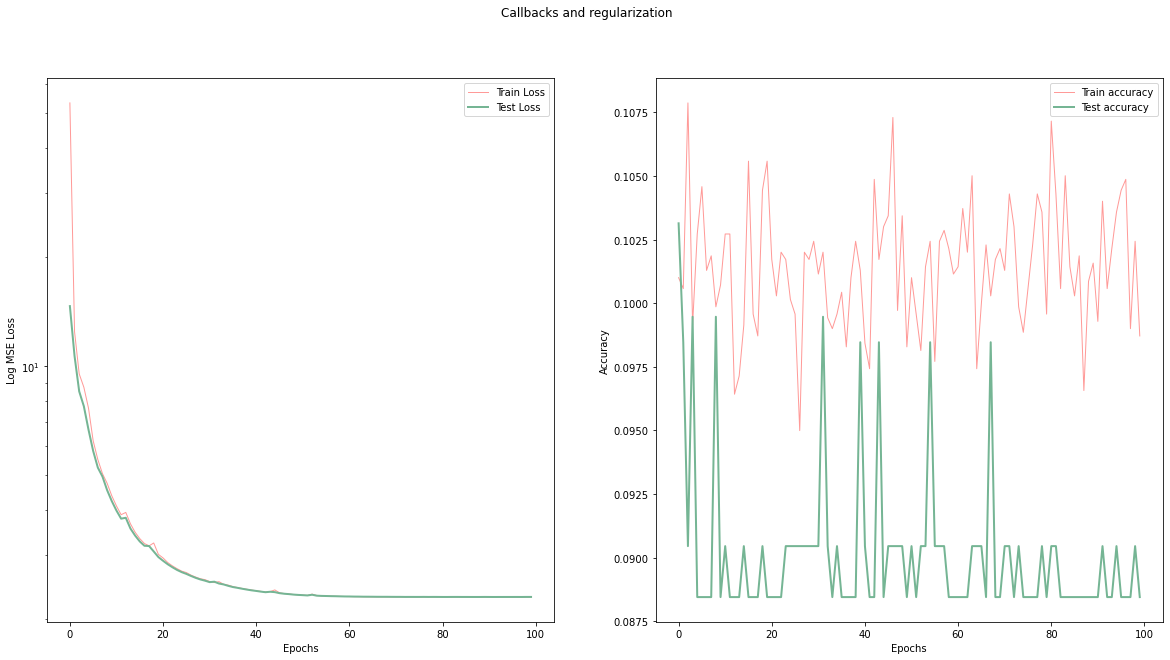

In [ ]:
fig,ax =plt.subplots(1,2,figsize=(20,10))
fig.suptitle("Callbacks and regularization")
ax[0].semilogy(history4.history['loss'], label='Train Loss', color='#FF9A98', linewidth=1)
ax[0].semilogy(history4.history['val_loss'],  label='Test Loss', color='#75B594', linewidth=2)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Log MSE Loss')
ax[0].legend()

ax[1].plot(history4.history['accuracy'], label='Train accuracy', color='#FF9A98', linewidth=1)
ax[1].plot(history4.history['val_accuracy'],  label='Test accuracy', color='#75B594', linewidth=2)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

#### Confusion Matrix

In [ ]:
y_pred_m4 = ffnn_model4.predict(x_test)

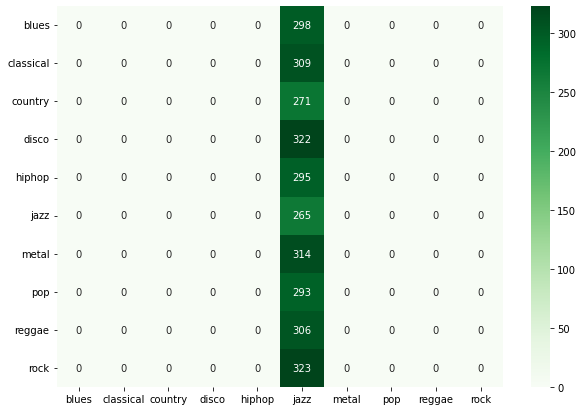

In [ ]:
y_pred=[]
for i in y_pred_m4:
    y_pred.append(np.argmax(i))
    
cm1 = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm1, index = [i for i in labels],
              columns = [i for i in labels])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm,annot=True,cmap="Greens",fmt='g')
plt.savefig('confusion_mrtx4.png',bbox_inches = 'tight')

### Model 5

Layers Used - Dense, Flatten, Batch Normalization
Regularizer Used - None
Callbacks Used - None

In [ ]:
ffnn_model5 = models.Sequential(name="BatchNorm")
# The Inputs
ffnn_model5.add(Input(shape=(X.shape[1],X.shape[2])))
# flatten layer
ffnn_model5.add(Flatten())
ffnn_model5.add(BatchNormalization())
# first dense layer
ffnn_model5.add(Dense(512,activation='relu',name='dense1'))
ffnn_model5.add(BatchNormalization())
# second dense layer
ffnn_model5.add(Dense(256,activation='relu',name='dense2'))
ffnn_model5.add(BatchNormalization())
# third dense layer
ffnn_model5.add(Dense(128,activation='relu',name='dense3'))
ffnn_model5.add(BatchNormalization())
# fourth dense layer
ffnn_model5.add(Dense(64,activation='relu',name='dense4'))
# fifth dense layer
#ffnn_model5.add(Dense(32,activation='relu',name='dense5'))
ffnn_model5.add(BatchNormalization())
# Output layer
ffnn_model5.add(Dense(10,activation='softmax',name='output'))
# Print the model summary
print(ffnn_model5.summary())
# Compile the model.
ffnn_model5.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# Fit the model and store the history in a varibale.
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history5 = ffnn_model5.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=32, callbacks = tensorboard_callback, verbose = 0)

Model: "BatchNorm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 1690)              0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 1690)              6760      
_________________________________________________________________
dense1 (Dense)               (None, 512)               865792    
_________________________________________________________________
batch_normalization_11 (Batc (None, 512)               2048      
_________________________________________________________________
dense2 (Dense)               (None, 256)               131328    
_________________________________________________________________
batch_normalization_12 (Batc (None, 256)               1024      
_________________________________________________________________
dense3 (Dense)               (None, 128)               32

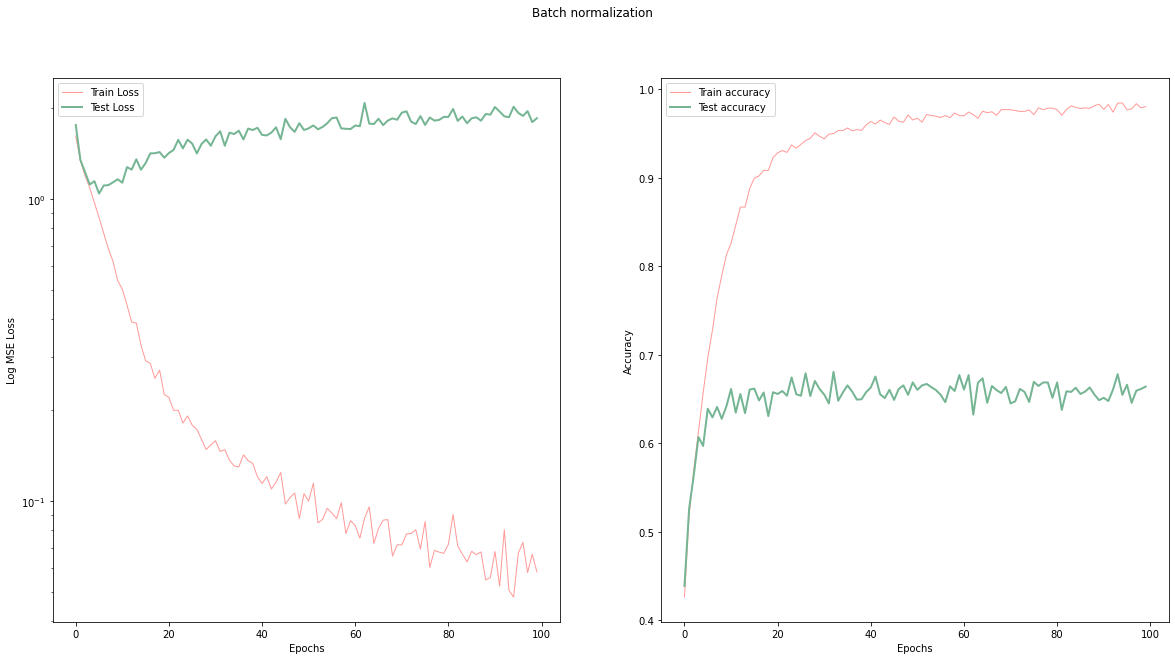

In [ ]:
fig,ax =plt.subplots(1,2,figsize=(20,10))
fig.suptitle("Batch normalization")
ax[0].semilogy(history5.history['loss'], label='Train Loss', color='#FF9A98', linewidth=1)
ax[0].semilogy(history5.history['val_loss'],  label='Test Loss', color='#75B594', linewidth=2)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Log MSE Loss')
ax[0].legend()

ax[1].plot(history5.history['accuracy'], label='Train accuracy', color='#FF9A98', linewidth=1)
ax[1].plot(history5.history['val_accuracy'],  label='Test accuracy', color='#75B594', linewidth=2)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

#### Confusion Matrix

In [ ]:
y_pred_m5 = ffnn_model5.predict(x_test)

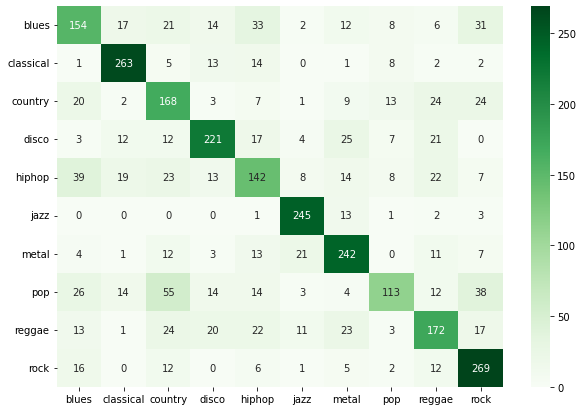

In [ ]:
y_pred=[]
for i in y_pred_m5:
    y_pred.append(np.argmax(i))
    
cm1 = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm1, index = [i for i in labels],
              columns = [i for i in labels])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm,annot=True,cmap="Greens",fmt='g')
plt.savefig('confusion_mrtx5.png',bbox_inches = 'tight')

### Model 6

Layers Used - Dense, Flatten, Batch Normalization
Regularizer Used - L2
Callbacks Used - None

In [ ]:
ffnn_model6 = models.Sequential(name="BatchNorm")
# The Inputs
ffnn_model6.add(Input(shape=(X.shape[1],X.shape[2])))
# flatten layer
ffnn_model6.add(Flatten())
ffnn_model6.add(BatchNormalization())
# first dense layer
ffnn_model6.add(Dense(512,activation='relu',kernel_regularizer=reg,name='dense1'))
ffnn_model6.add(BatchNormalization())
# second dense layer
ffnn_model6.add(Dense(256,activation='relu',kernel_regularizer=reg,name='dense2'))
ffnn_model6.add(BatchNormalization())
# third dense layer
ffnn_model6.add(Dense(128,activation='relu',kernel_regularizer=reg,name='dense3'))
ffnn_model6.add(BatchNormalization())
# fourth dense layer
ffnn_model6.add(Dense(64,activation='relu',kernel_regularizer=reg,name='dense4'))
# fifth dense layer
#ffnn_model5.add(Dense(32,activation='relu',name='dense5'))
ffnn_model6.add(BatchNormalization())
# Output layer
ffnn_model6.add(Dense(10,activation='softmax',name='output'))
# Print the model summary
print(ffnn_model6.summary())
# Compile the model.
ffnn_model6.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# Fit the model and store the history in a varibale.
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history6 = ffnn_model6.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=32, callbacks = tensorboard_callback, verbose = 0)

Model: "BatchNorm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 1690)              0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 1690)              6760      
_________________________________________________________________
dense1 (Dense)               (None, 512)               865792    
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
dense2 (Dense)               (None, 256)               131328    
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
dense3 (Dense)               (None, 128)               32

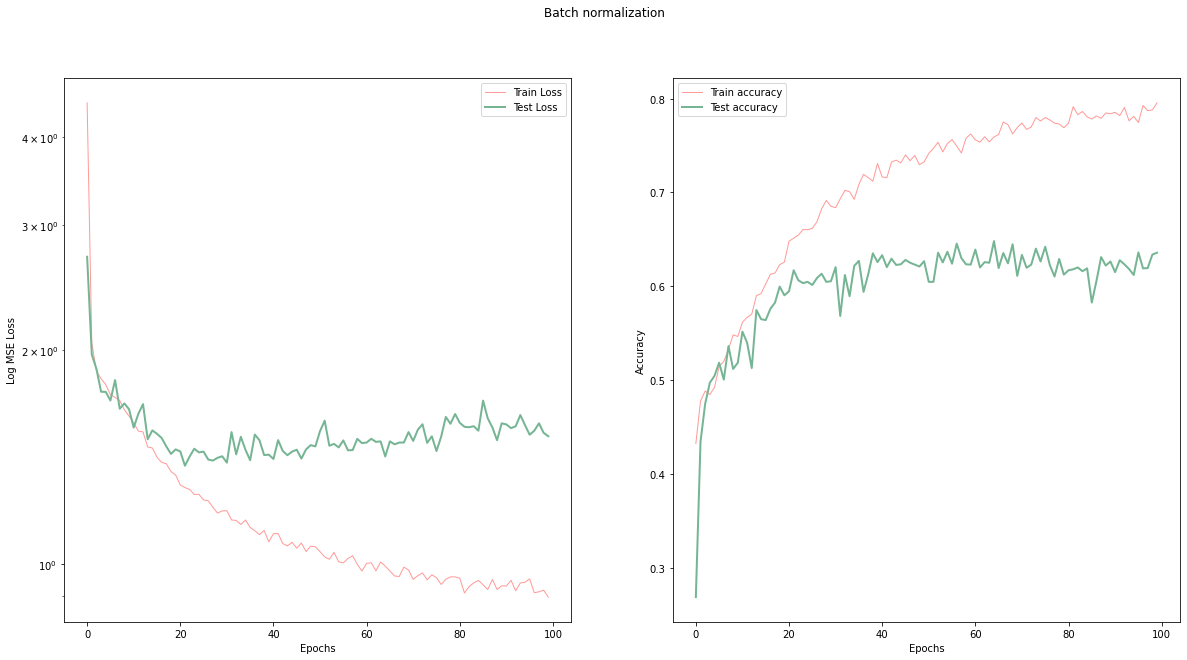

In [ ]:
fig,ax =plt.subplots(1,2,figsize=(20,10))
fig.suptitle("Batch normalization")
ax[0].semilogy(history6.history['loss'], label='Train Loss', color='#FF9A98', linewidth=1)
ax[0].semilogy(history6.history['val_loss'],  label='Test Loss', color='#75B594', linewidth=2)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Log MSE Loss')
ax[0].legend()

ax[1].plot(history6.history['accuracy'], label='Train accuracy', color='#FF9A98', linewidth=1)
ax[1].plot(history6.history['val_accuracy'],  label='Test accuracy', color='#75B594', linewidth=2)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

#### Confusion Matrix

In [ ]:
y_pred_m6 = ffnn_model6.predict(x_test)

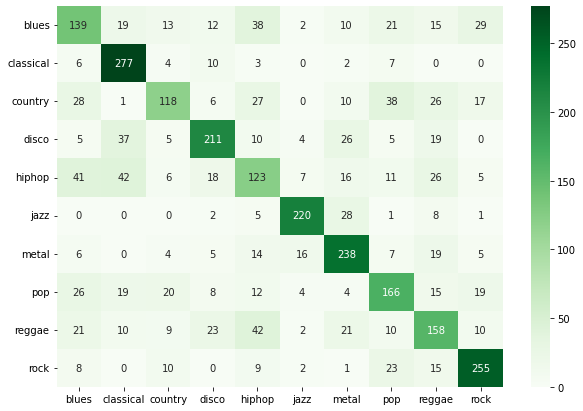

In [ ]:
y_pred=[]
for i in y_pred_m6:
    y_pred.append(np.argmax(i))
    
cm1 = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm1, index = [i for i in labels],
              columns = [i for i in labels])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm,annot=True,cmap="Greens",fmt='g')
plt.savefig('confusion_mrtx6.png',bbox_inches = 'tight')

### Tensorboard Graphs for all the models.

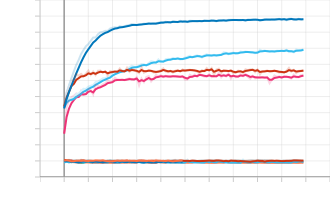

In [ ]:
Image(filename='epoch_accuracy_ffnn.png')

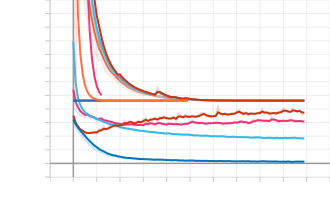

In [ ]:
Image(filename='epoch_loss_ffnn.png')

## CNNs - Convolutional Neural Networks

CNNs are regularized versions of multilayer perceptrons. Multilayer perceptrons usually mean fully connected networks, that is, each neuron in one layer is connected to all neurons in the next layer. The "full connectivity" of these networks make them prone to overfitting data. Typical ways of regularization, or preventing overfitting, include: penalizing parameters during training (such as weight decay) or trimming connectivity (skipped connections, dropout, etc.) CNNs take a different approach towards regularization: they take advantage of the hierarchical pattern in data and assemble patterns of increasing complexity using smaller and simpler patterns embossed in their filters. Therefore, on a scale of connectivity and complexity, CNNs are on the lower extreme.

Types of layers used -
1. Dense
2. Flatten
3. Dropout
4. Batch Normalization
5. Max-Pooling 2D
6. Convolutional 2D

#### Max-Pooling Layers
Max pooling is a pooling operation that selects the maximum element from the region of the feature map covered by the filter. Thus, the output after max-pooling layer would be a feature map containing the most prominent features of the previous feature map.

#### Convolutional Layers
A convolutional layer is the main building block of a CNN. It contains a set of filters (or kernels), parameters of which are to be learned throughout the training. The size of the filters is usually smaller than the actual image. Each filter convolves with the image and creates an activation map.

In [ ]:
## Convolution Networks expect a channel.
X_train = x_train[..., np.newaxis]
X_test = x_test[..., np.newaxis]

input_shape = X_train[0].shape

In [ ]:
## Function to plot the history from training the Neural Network
def plot_history(history, name):
    with plt.xkcd(scale=0.2):
      fig, ax = plt.subplots(1,2, figsize=(12,6))
      for i, metric in enumerate(['loss', 'accuracy']): 
          ax[i].plot(history.history[metric], label='Train', color='#EFAEA4',linewidth=3)
          ax[i].plot(history.history[f'val_{metric}'], label='Validation', color='#B2D7D0',linewidth=3)
          if metric == 'accuracy': 
            ax[i].axhline(0.5, color='#8d021f', ls='--', label='Trivial accuracy')
            ax[i].set_ylabel("Accuracy", fontsize=14)
          else:
            ax[i].set_ylabel("Loss", fontsize=14)
          ax[i].set_xlabel('Epoch', fontsize=14)

      plt.suptitle(f'{name} Training', y=1.05, fontsize=16)
      plt.legend(loc='best')
      plt.tight_layout()
    

In [ ]:
## CNN Model
def build_basic_CNN_model(input_shape, filters_per_layer, weight_decay = 1e-4):
    
    model = Sequential()

    model.add(Input(shape = input_shape))

    ## Layer 1
    model.add(Conv2D(filters_per_layer[0], (3, 3), activation = 'relu', kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(MaxPooling2D((2, 2), strides = (2, 2), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    ## Layer 2
    model.add(Conv2D(filters_per_layer[1], (3, 3), activation = 'relu', kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(MaxPooling2D((3, 3), strides = (2, 2), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    ## Layer 3
    model.add(Conv2D(filters_per_layer[2], (2, 2), activation = 'relu', kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(MaxPooling2D((3, 3), strides = (2, 2), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    ## Layer 4
    model.add(Conv2D(filters_per_layer[3], (1, 1), activation = 'relu', kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(MaxPooling2D((2, 2), strides = (2, 2), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    ## Flatten the output
    model.add(Flatten())

    ## Add a Dense layer
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.3))

    ## Add the output layer
    model.add(Dense(10, activation = 'softmax'))

    ## Print the model Summary
    ##model.summary()
    return model

In [ ]:
## Combinations of filters per layer
filter_combinations = [ [32, 32, 32, 32],
          [64, 32, 32, 32],
          [128, 64, 64, 32],
          [256, 128, 64, 64],
          [256, 128, 64, 32],
          [32, 64, 128, 256],
        [64, 128, 256, 256]
]


In [ ]:
## For each combination of filter size, 
## fit the model, and evaluate the architecture

history = []
eval_scores = []

for i in range(len(filter_combinations)):
    
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
    ## Callbacks

    ## Early Stopping
    early_stopping_callback = EarlyStopping(monitor = "val_loss",patience = 20)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    ## Learning Rate
    def lr_schedule(epoch):
        lrate = 0.0001
        if epoch > 25:
            lrate = 0.00005
        if epoch > 100:
            lrate = 0.00003
        return lrate

    lr_callback = LearningRateScheduler(lr_schedule)

    ## Model Checkpoint


    ## Putting it all together
    cnn_callbacks = [early_stopping_callback, lr_callback, tensorboard_callback]
    print('Filter combinations: ', filter_combinations[i])
    
    ## Build the model
    model = build_basic_CNN_model(input_shape, filter_combinations[i])
    
    ## Compile the model
    model.compile(optimizer = Adam(learning_rate = 1e-4),
                  loss = 'sparse_categorical_crossentropy',
                    metrics = ['accuracy'])

    ## Train the model and plot the history
    h = model.fit(X_train, y_train,
                    validation_split = 0.2, batch_size = 32, 
                    epochs = 200, callbacks = cnn_callbacks,
                     verbose = 0)
    model.save(f'model{i}.h5')
    ## Append the history
    history.append(h)
    
    ## Evaluate the model against the test data
    scores = model.evaluate(X_test, y_test, verbose = 1)
    eval_scores.append(scores)
    print('Accuracy: %.3f loss: %.3f\n' % (scores[1]*100,scores[0]))

Filter combinations:  [32, 32, 32, 32]
94/94 [==============================] - 0s 3ms/step - loss: 1.0697 - accuracy: 0.6142
Accuracy: 61.415 loss: 1.070

Filter combinations:  [64, 32, 32, 32]
94/94 [==============================] - 0s 3ms/step - loss: 0.7630 - accuracy: 0.7443
Accuracy: 74.433 loss: 0.763

Filter combinations:  [128, 64, 64, 32]
94/94 [==============================] - 0s 4ms/step - loss: 0.5773 - accuracy: 0.8117
Accuracy: 81.175 loss: 0.577

Filter combinations:  [256, 128, 64, 64]
94/94 [==============================] - 1s 6ms/step - loss: 0.4680 - accuracy: 0.8652
Accuracy: 86.515 loss: 0.468

Filter combinations:  [256, 128, 64, 32]
94/94 [==============================] - 1s 7ms/step - loss: 0.5324 - accuracy: 0.8405
Accuracy: 84.045 loss: 0.532

Filter combinations:  [32, 64, 128, 256]
94/94 [==============================] - 0s 3ms/step - loss: 0.5872 - accuracy: 0.8208
Accuracy: 82.076 loss: 0.587

Filter combinations:  [64, 128, 256, 256]
94/94 [========

In [ ]:
## Print the Metrics in a tabular format
pt = PrettyTable()
pt.field_names = ['Filter Combinations','Accuracy', 'Loss']
for i in range(len(eval_scores)):
    pt.add_row([filter_combinations[i],round(eval_scores[i][1]*100,2),round(eval_scores[i][0],2)]) 
print(pt)

+---------------------+----------+------+
| Filter Combinations | Accuracy | Loss |
+---------------------+----------+------+
|   [32, 32, 32, 32]  |  70.29   | 0.88 |
|   [64, 32, 32, 32]  |  75.57   | 0.73 |
|  [128, 64, 64, 32]  |  77.84   | 0.72 |
|  [256, 128, 64, 64] |  85.65   | 0.5  |
|  [256, 128, 64, 32] |  87.15   | 0.45 |
|  [32, 64, 128, 256] |  79.17   | 0.72 |
| [64, 128, 256, 256] |  83.28   | 0.63 |
+---------------------+----------+------+


4 0.8714953064918518


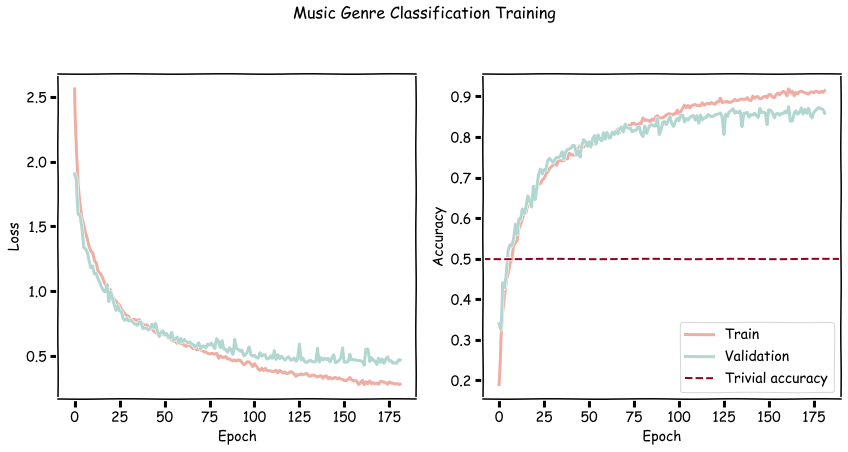

In [ ]:
## Plot the training history for the best model
best_accuracy = 0
best_idx = 0
for i in range(len(eval_scores)):
    if (eval_scores[i][1] >= best_accuracy):
        best_accuracy = eval_scores[i][1]
        best_idx = i
    
print(best_idx, best_accuracy)    
## Plot the history
plot_history(history[best_idx], 'Music Genre Classification')

#### Confusion Matrices fro all the models.

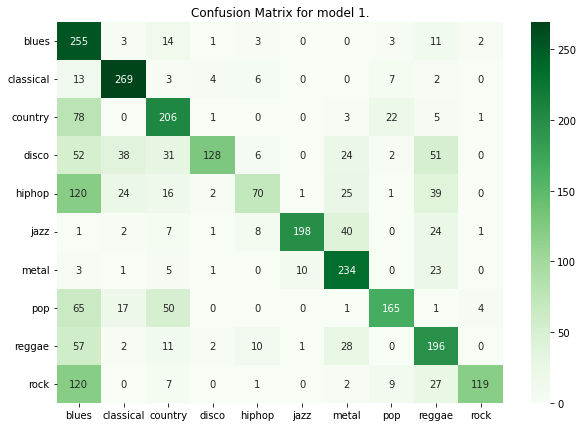

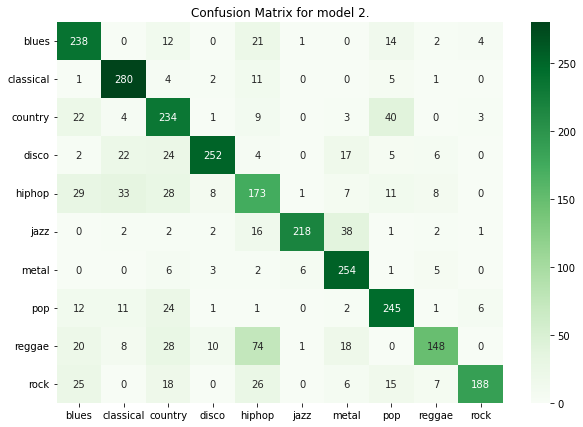

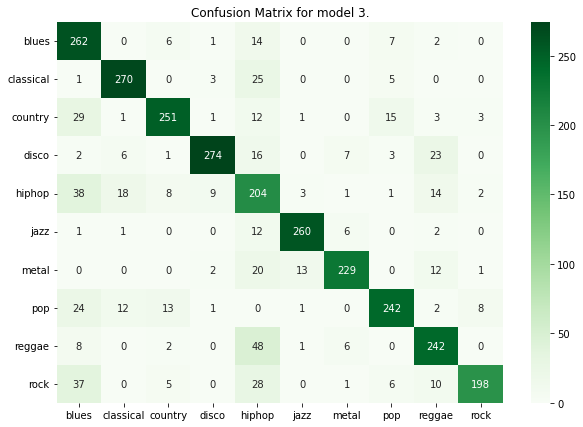

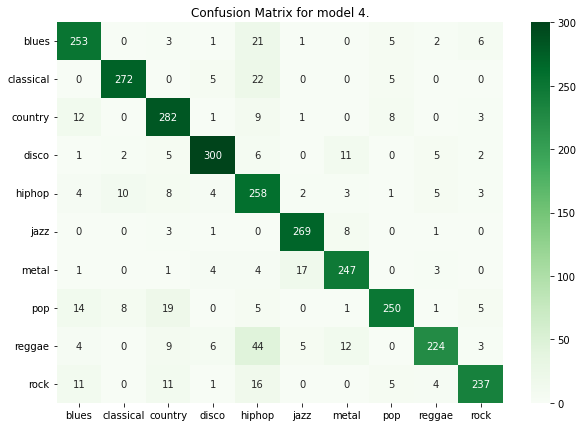

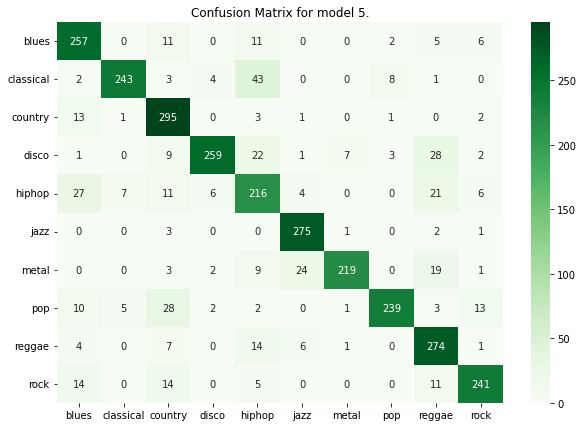

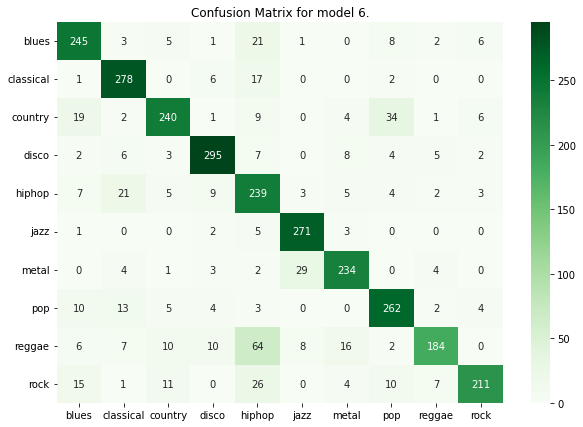

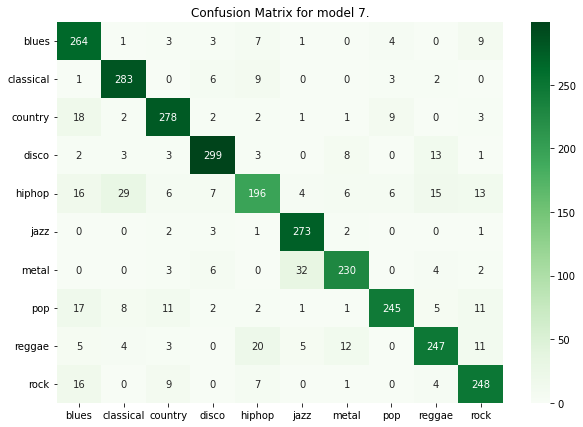

In [ ]:
for num in range(7):
    model = load_model(f'model{num}.h5')
    y_cnn_pred = model.predict(X_test)
    y_cnn = []
    for i in y_cnn_pred:
        y_cnn.append(np.argmax(i))
    cm1 = confusion_matrix(y_test, y_cnn)
    df_cm = pd.DataFrame(cm1, index = [i for i in labels],
                  columns = [i for i in labels])
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm,annot=True,cmap="Greens",fmt='g').set_title(f'Confusion Matrix for model {num + 1}.')
    plt.savefig(f'confusion_mrtx_cnn{num}.png',bbox_inches = 'tight')

### Tensorboard Graphs for all the models.

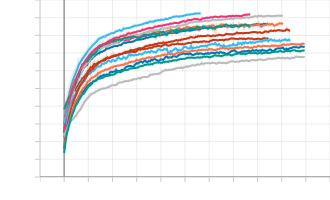

In [ ]:
Image(filename='epoch_accuracy_cnn.png')

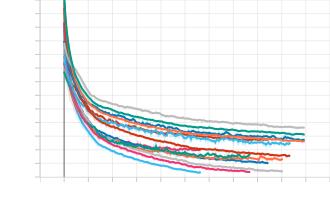

In [ ]:
Image(filename='epoch_loss_cnn.png')

## Saliency Maps

We know that CNNs extract features that best helps us to perform our downstream task (e.g. classification).
The resulting feature maps are matrices, that we can interpret as images. As such, we can analyze them a look for relevant patterns.
What to Visualize for CNNs?
The first things to try are:
1. visualize the result of applying a learned filter to an image
2. visualize the filters themselves

In [ ]:
def get_cassified_img(model,x=X_test,y=y_test):
    new_shape = (1,130,13,1)
    correct_img=0
    incorrect_img=0
    for i in range(150,len(y)):
        sample_img = np.rot90(x[i])
        x_conv =val1=np.resize(sample_img,new_shape)
        y_pred=model.predict(x_conv)
        y_pred=np.argmax(y_pred)
        if y_pred == y[i] and not correct_img:
            correct_img = [sample_img,x_conv,y_pred]
        elif y_pred != y[i] and not incorrect_img:
            incorrect_img = [sample_img,x_conv,y_pred]
        
        if incorrect_img and correct_img:
            break
    return correct_img,incorrect_img

In [ ]:
def plot_saliency(original,saliency,gradcam,label):
    fig,ax = plt.subplots(1,3,figsize=(30,10))
    
    fig.suptitle(label,fontsize=20)
    ax[0].imshow(original, extent=[0,100,0,1],aspect=100,cmap='RdBu_r')
    ax[0].set_title('Original MFCC plot')
    ax[0].axis('off')
    
    ax[1].imshow((saliency[0].T), cmap = 'jet', extent=[0,100,0,1],aspect=100)
    ax[1].set_title('Saliency map')
    ax[1].axis('off')
    
    ax[2].imshow(gradcam,alpha=0.3, extent=[0,100,0,1],aspect=100)
    ax[2].set_title('Grad cam')
    ax[2].axis('off')
    plt.savefig(label)

In [ ]:
def saliency_map(model):
    cor_img,incor_img=get_cassified_img(model)
    score_cor = CategoricalScore([cor_img[2]])
    score_incor = CategoricalScore([incor_img[2]])
    
    # saliency map for correctly classified 
    saliency_cor = Saliency(model,model_modifier = ReplaceToLinear(),clone=True)

    smoothgrad_saliency_map_cor = saliency_cor(score_cor, cor_img[1], smooth_samples=20,smooth_noise=0.20)
    
    # saliency map for incorrectly classified 
    saliency_incor = Saliency(model,model_modifier = ReplaceToLinear(),clone=True)

    smoothgrad_saliency_map_incor = saliency_incor(score_incor, incor_img[1], smooth_samples=20,smooth_noise=0.20)
    
    # Gradcam for correctly classified
    gradcam_cor = Gradcam(model,model_modifier = ReplaceToLinear(),clone=True)
    cam = gradcam_cor(score_cor,cor_img[1],penultimate_layer=-5)
    gradcam_heatmap_cor = np.uint8(cm.jet(cam[0])[..., :3] * 255)
    
    # Gradcam for incorreclty classified
    gradcam_incor = Gradcam(model,model_modifier = ReplaceToLinear(),clone=True)
    cam = gradcam_incor(score_incor,incor_img[1],penultimate_layer=-5)
    gradcam_heatmap_incor = np.uint8(cm.jet(cam[0])[..., :3] * 255)
    
    # invoke the plotting functions
    plot_saliency(cor_img[0],smoothgrad_saliency_map_cor,gradcam_heatmap_cor,label='Correctly classified')
    
    plot_saliency(incor_img[0],smoothgrad_saliency_map_incor,gradcam_heatmap_incor,label='Incorrectly classified')

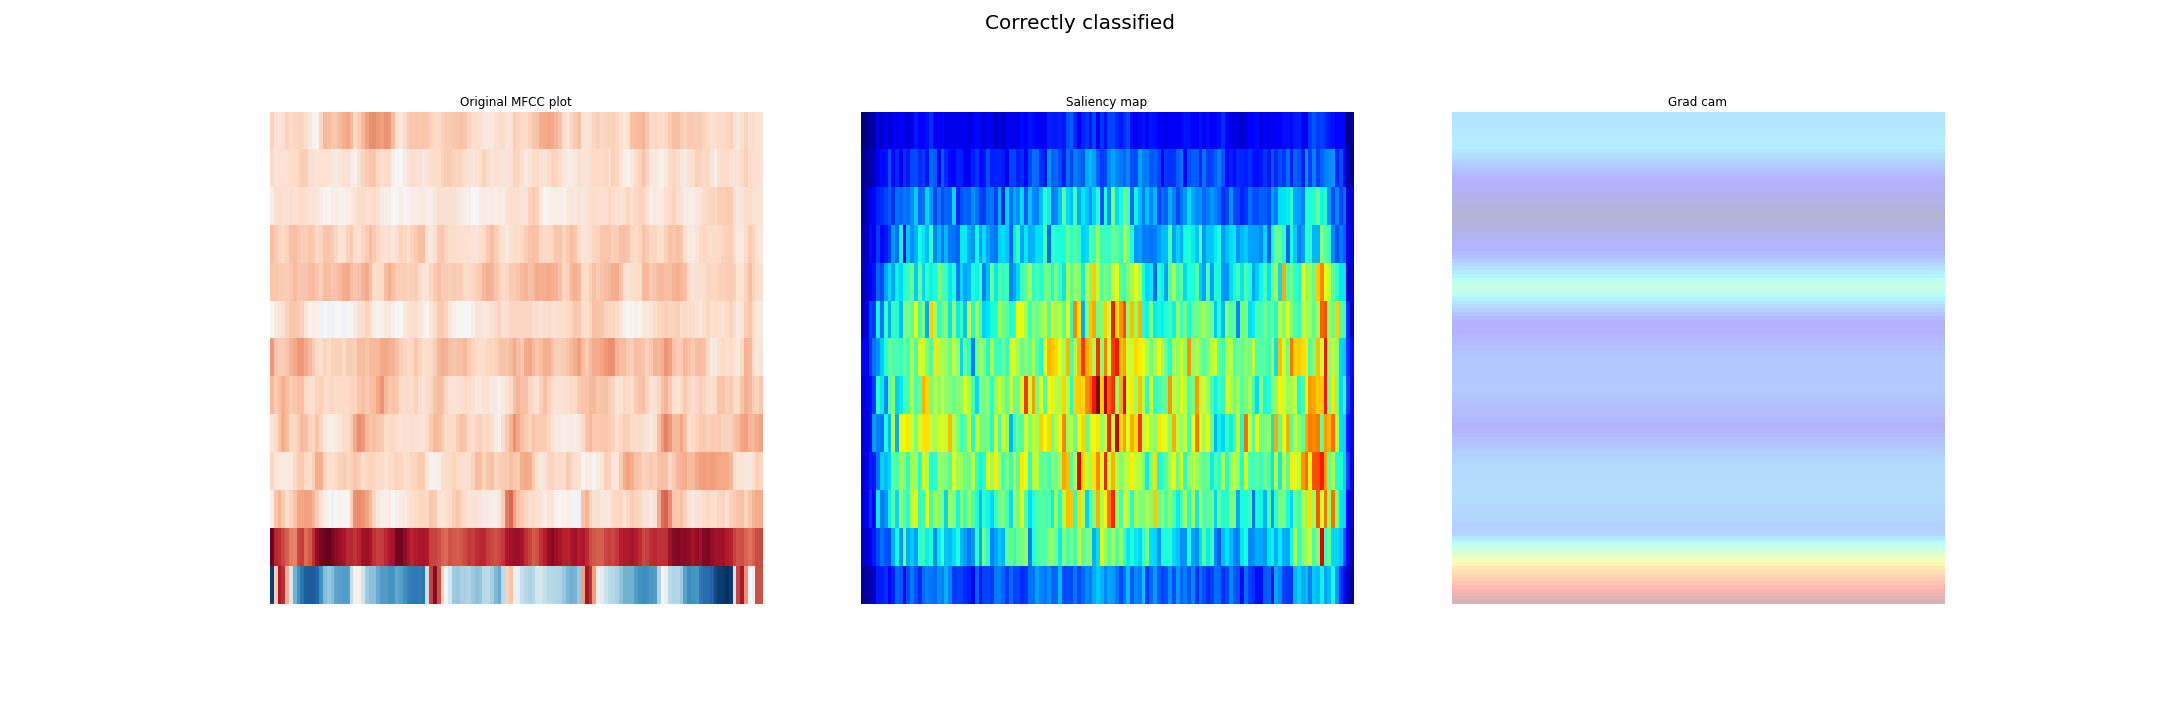

In [ ]:
Image(filename='Correctly classified.png')

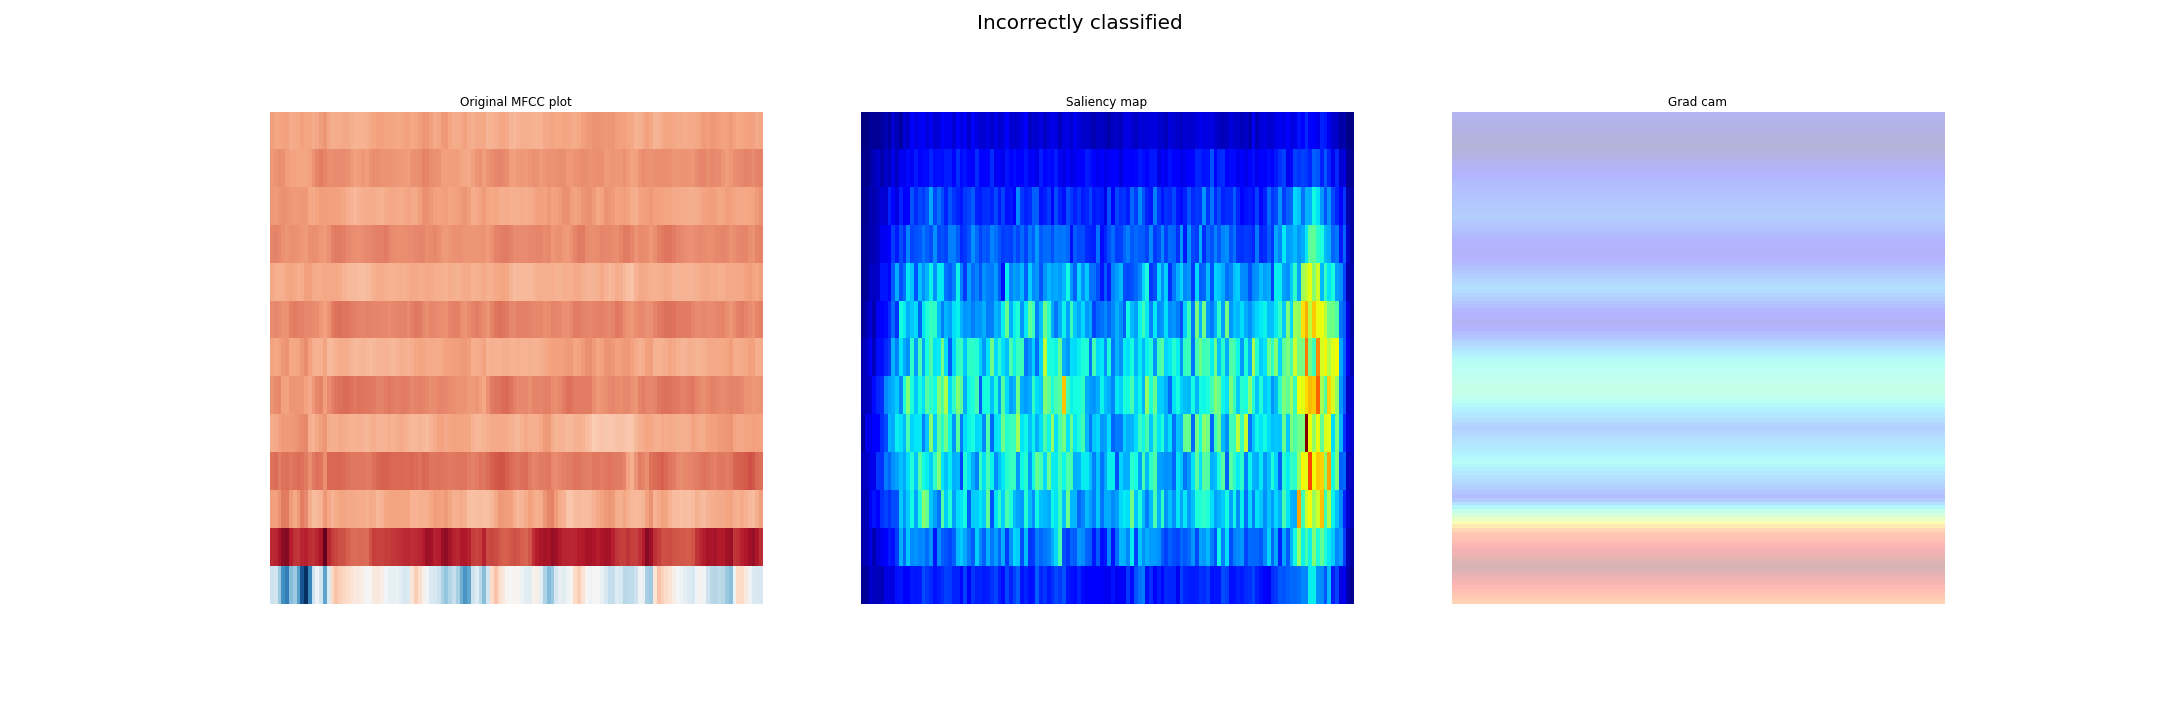

In [ ]:
Image(filename='Incorrectly classified.png')

### Interpretation

Saliency maps tend to help visualising what the model is looking for in an image classification problems, but because we are dealing with the audion files, the MFCC maps and saliency maps are not of much help to us.
Vaguely what we can figure out is if the model is focusing at a larger area of the MFCC, it tends to classify the audio file to the correct genre and vice-versa.

#### Reconstruction of audio from Saliency maps.

As we figured out from the saliency maps, the visual representation is notof any help. So, we tried to reconstruct the audio bits that model is trying to recognise from the saliency maps. 
But, getting back the MFCC coefficients from the saliency map seemed to be impossible. 
This could be a future task to undertake.

## Tensorboard

The following cell brings out the html object of tensorboard. We ran it saved the graphs and used them as images.

In [ ]:
%tensorboard --logdir logs/fit

## Testing on new songs.

The reliability of any model is dependant on real-world tests, not the validation tests.
So, to do the same, we decide to take 2 of our favorite songs and classify them into the respective genres. The results were pretty good.

#### Songs -
1. Martin Garrix - Animals
2. In The End - Linkin Park

We wrote a function that takes the audio file of any song and returns the classification of the song.

In [ ]:
def predict(file_path, model,labels):
    signal, sr = librosa.load(file_path, sr=22050)
    limit = 22050 * 3
    SAMPLE_RATE = 22050
    hop_length=512
    n_mfcc=13
    n_fft=2048
    data = {
            "mapping": [],
            "mfcc": [],
            "labels": []
        }
    for i in range(0, len(signal),limit):
        signal = signal[:limit]
        mfcc = librosa.feature.mfcc(signal, sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)
        mfcc = mfcc.T
        data["mfcc"].append(mfcc.tolist())
        data["labels"].append(i-1)
    X = np.array(data['mfcc'])
    X_new = X[..., np.newaxis]
    y_new = model.predict(X_new)
    y_animals = []
    for i in y_new:
        y_animals.append(np.argmax(i))
    dictionary = {}
    for i in y_animals:
        if i in dictionary.keys():
            dictionary[i] = dictionary[i] + 1
        else:
            dictionary[i] = 1
    list1 = []
    for i in dictionary.keys():
        list1.append(labels[i])   
    return list1

In [ ]:
model = load_model(f'model4.h5') ## Load the best model from the saved models.

### Song 1 - Martin Garrix - Animals 

In [ ]:
prediction  = predict('Martin Garrix - Animals (Official Video).wav',model, labels)
for i in prediction:
    print(i)

reggae


We chose this song just because we like it very much. This does not lie clearly in any of the 10 labels that our model was trained on. Yet, the result was surprising as 
1. All the parts were recognised as the same genre.
2. 'Reggae' genre is the closest of all that can be out of the 10 genres we have. The song technically is an EDM which is a separate genre of its own.

### Song 2 - In The End  - Linkin Park

In [ ]:
prediction  = predict('In The End [Official HD Music Video] - Linkin Park.wav',model, labels)
for i in prediction:
    print(i)

rock


To summarise the testing, we decided to take up on one of the all time hits of Linkin Park - In The End.
Again the model categorised all of its parts as the same genre, that is 'rock', which is 100% accurate this time.

## Conclusion

To conclude the findings of the project, we figured out that FFNNs do not perform particularly well with transformed audio data. The maximum accuracy we were able to achieve was - 65.7%.

On the other hand, CNNs performed better. We achieved an accuracy of 87.15% on test data.

Conversion of audio data to MFCCs simplified the inputs to the model. When trying to perform the same using signal data or STFTs we discovered that the input size exploded. Due to limited resources we were unable to test the same.

Due to the temporal nature of the data, we believe that Recurrent Neural Networks (RNNs) or Long-Short Term Memory (LSTMs) may perform better.